In [16]:
# The extract_features function gets a patch directory and a feature directory.
# the function will extract the features of the patches inside the folder
# and saves them in a pickle file of dictionary mapping patch names to features.


# config variables ---------------------------------------------
patch_dir = "D:\ISEN\M1\Projet M1\DLBCL-Morph\Patches\HE"
extracted_features_save_adr = "./extracted_features.pickle"
network_weights_address = "./weights/KimiaNetKerasWeights.h5"
network_input_patch_width = 224
batch_size = 30
img_format = 'png'
# =============================================================


# importing libraries----------------------------------------------------
import os

import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Lambda
# from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.backend import bias_add, constant
import pandas as pd
import glob, pickle, skimage.io, pathlib
import numpy as np
from tqdm import tqdm
from keras.layers import Dense

In [17]:
# feature extractor preprocessing function
def preprocessing_fn(input_batch, network_input_patch_width):
    org_input_size = tf.shape(input_batch)[1]

    # standardization
    scaled_input_batch = tf.cast(input_batch, 'float') / 255.

    # resizing the patches if necessary
    resized_input_batch = tf.cond(tf.equal(org_input_size, network_input_patch_width),
                                  lambda: scaled_input_batch,
                                  lambda: tf.image.resize(scaled_input_batch,
                                                          (network_input_patch_width, network_input_patch_width)))

    # normalization, this is equal to tf.keras.applications.densenet.preprocess_input()---------------
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    data_format = "channels_last"
    mean_tensor = constant(-np.array(mean))
    standardized_input_batch = bias_add(resized_input_batch, mean_tensor, data_format)
    standardized_input_batch /= std
    # =================================================================================================

    return standardized_input_batch

In [18]:
# Create the train dataset based on patches
def create_train_dataset(patch_dir):
    patient_df = pd.read_csv('D:\ISEN\M1\Projet M1\KimiaNet\clinical_data_with_no_missing_values.csv')
    y_data = patient_df[['patient_id', 'Follow-up Status']]
    train_dataset = []
    for dirs in os.listdir(patch_dir):
        patient_id = dirs
        for files in os.listdir(patch_dir + "\\" + dirs):
            if files.endswith(".png"):
                image_data = skimage.io.imread(patch_dir + "\\" + dirs + "\\" + files)
                train_dataset.append([image_data, patient_id])

    x_train = []
    y_train = []
    for i in range(len(train_dataset)):
        x_train.append(train_dataset[i][0])
        y_data['patient_id'] = y_data['patient_id'].astype(str)
        y_train.append(y_data[y_data['patient_id'] == train_dataset[i][1]]['Follow-up Status'].values[0])
    return x_train, y_train

In [19]:
from keras.layers import Dropout
from keras.layers import BatchNormalization


# feature extractor initialization function
def kimianet_feature_extractor(network_input_patch_width, weights_address, x_train, y_train):
    dnx = DenseNet121(include_top=False, weights=weights_address,
                      input_shape=(network_input_patch_width, network_input_patch_width, 3), pooling='avg')

    kn_feature_extractor = Model(inputs=dnx.input, outputs=GlobalAveragePooling2D()(dnx.layers[-3].output))

    kn_feature_extractor_seq = Sequential([Lambda(preprocessing_fn,
                                                  arguments={'network_input_patch_width': network_input_patch_width},
                                                  input_shape=(None, None, 3), dtype=tf.uint8)])

    kn_feature_extractor_seq.add(kn_feature_extractor)
    kn_feature_extractor_seq.add(Dense(512, activation='relu'))
    kn_feature_extractor_seq.add(BatchNormalization())
    kn_feature_extractor_seq.add(Dropout(0.4))
    kn_feature_extractor_seq.add(Dense(128, activation='relu'))
    kn_feature_extractor_seq.add(BatchNormalization())
    kn_feature_extractor_seq.add(Dropout(0.2))
    kn_feature_extractor_seq.add(Dense(32, activation='relu'))
    kn_feature_extractor_seq.add(Dense(1, activation='sigmoid'))

    kn_feature_extractor_seq.layers[1].trainable = False

    return kn_feature_extractor_seq

In [20]:
# feature extraction function
def extract_features(patch_dir, extracted_features_save_adr, network_weights_address,
                     network_input_patch_width, batch_size, img_format, x_train, y_train):
    feature_extractor = kimianet_feature_extractor(network_input_patch_width, network_weights_address, x_train, y_train)
    feature_dict = {}
    # get the list of patch addresses
    for paths, dirs, files in os.walk(patch_dir):
        patch_adr_list = [pathlib.Path(os.path.join(paths, x)) for x in files if x.endswith(img_format)]
        patient = paths.split('\\')[-1]
        for batch_st_ind in tqdm(range(0, len(patch_adr_list), batch_size)):  # tqdm is for progress bar
            batch_end_ind = min(batch_st_ind + batch_size, len(patch_adr_list))
            batch_patch_adr_list = patch_adr_list[batch_st_ind:batch_end_ind]
            patch_batch = np.array([skimage.io.imread(x) for x in batch_patch_adr_list])
            batch_features = feature_extractor.predict(patch_batch)
            if patient in feature_dict.keys():
                feature_dict[patient].update(dict(zip([x.stem for x in batch_patch_adr_list], list(batch_features))))
            else:
                feature_dict.update({patient: dict(zip([x.stem for x in batch_patch_adr_list], list(batch_features)))})
    # patch_adr_list = [pathlib.Path(x) for x in glob.glob(patch_dir+'*.'+img_format)]

    with open(extracted_features_save_adr, 'wb') as output_file:
        pickle.dump(feature_dict, output_file, pickle.HIGHEST_PROTOCOL)

In [22]:
from sklearn.model_selection import train_test_split

# main function
X, y = create_train_dataset(patch_dir)
x_train, x_test, y_train, y_test = train_test_split(X,y ,random_state=104, test_size=0.2, shuffle=True)
kn_feature_extractor_seq = kimianet_feature_extractor(network_input_patch_width, network_weights_address, x_train, y_train)
kn_feature_extractor_seq.summary()
kn_feature_extractor_seq.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\julie\AppData\Local\Temp\ipykernel_2632\1058371846.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_data['patient_id'] = y_data['patient_id'].astype(str)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, None, 3)     0         
                                                                 
 model (Functional)          (None, 1024)              7037504   
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7,632,129
Trainable params: 594,625
Non-tr

In [28]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(24005, 224, 224, 3)
(24005,)
(6002, 224, 224, 3)
(6002,)


In [29]:
kn_feature_extractor_seq.fit(x_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(x_test, y_test))

Epoch 1/10
751/751 [==============================] - 75s 86ms/step - loss: 0.5999 - accuracy: 0.6846 - val_loss: 0.5787 - val_accuracy: 0.6993
Epoch 2/10
751/751 [==============================] - 62s 83ms/step - loss: 0.5380 - accuracy: 0.7278 - val_loss: 0.6454 - val_accuracy: 0.6203
Epoch 3/10
751/751 [==============================] - 63s 84ms/step - loss: 0.4949 - accuracy: 0.7587 - val_loss: 0.6106 - val_accuracy: 0.7121
Epoch 4/10
751/751 [==============================] - 63s 84ms/step - loss: 0.4613 - accuracy: 0.7778 - val_loss: 0.4782 - val_accuracy: 0.7587
Epoch 5/10
751/751 [==============================] - 63s 84ms/step - loss: 0.4341 - accuracy: 0.7964 - val_loss: 0.5102 - val_accuracy: 0.7381
Epoch 6/10
751/751 [==============================] - 64s 85ms/step - loss: 0.4069 - accuracy: 0.8119 - val_loss: 0.4972 - val_accuracy: 0.7672
Epoch 7/10
751/751 [==============================] - 65s 86ms/step - loss: 0.3834 - accuracy: 0.8226 - val_loss: 0.4554 - val_accuracy:

In [30]:
kn_feature_extractor_seq.save('D:\ISEN\M1\Projet M1\KimiaNet\kimianet.h5')

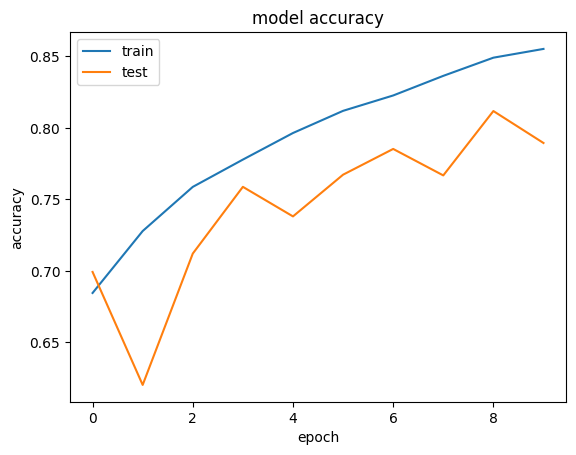

In [35]:
from matplotlib import pyplot as plt

plt.plot(kn_feature_extractor_seq.history.history['accuracy'])
plt.plot(kn_feature_extractor_seq.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


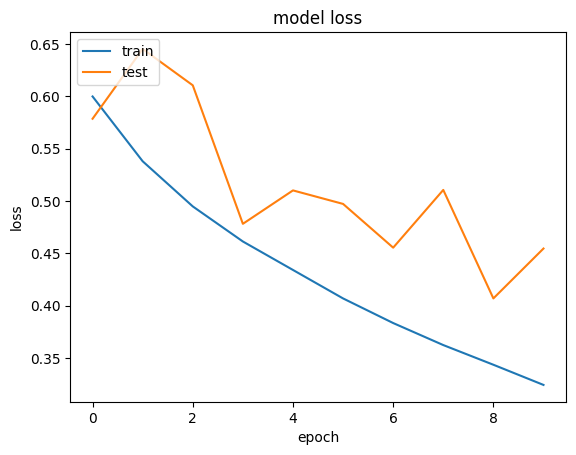

In [36]:
plt.plot(kn_feature_extractor_seq.history.history['loss'])
plt.plot(kn_feature_extractor_seq.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


188/188 [==============================] - 13s 61ms/step


Text(0.5, 1.0, 'Confusion matrix')

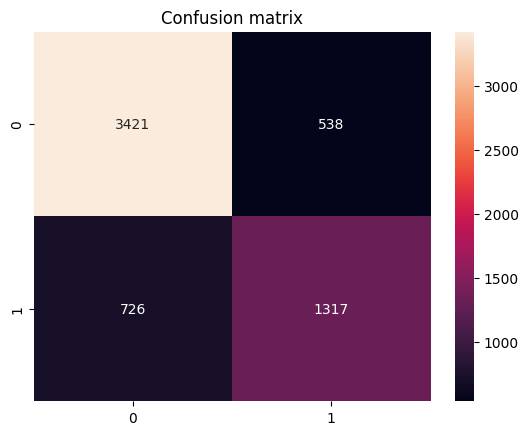

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

y_pred = kn_feature_extractor_seq.predict(x_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')


In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      3959
           1       0.71      0.64      0.68      2043

    accuracy                           0.79      6002
   macro avg       0.77      0.75      0.76      6002
weighted avg       0.79      0.79      0.79      6002



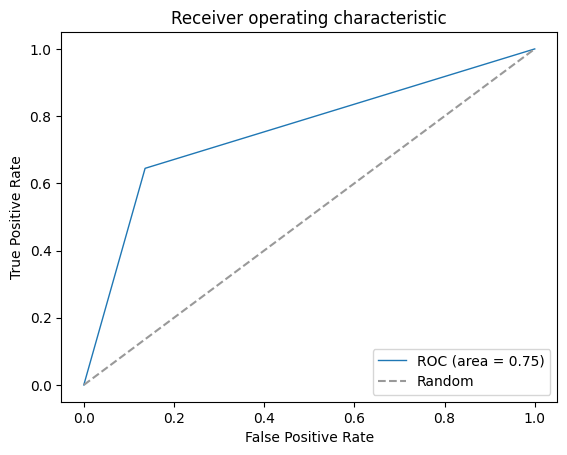

In [39]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [40]:
from sklearn.metrics import precision_recall_curve

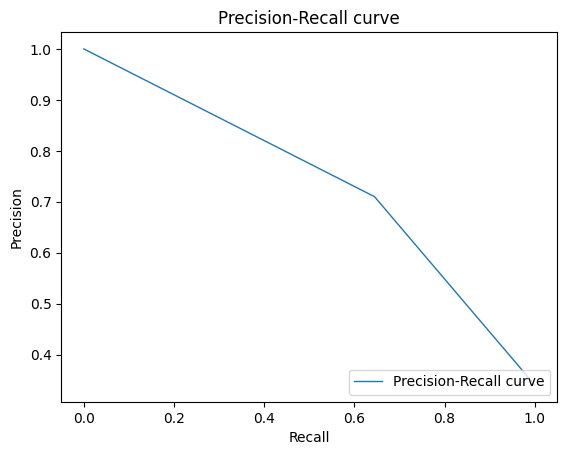

In [41]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision, lw=1, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")